In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

## This dataset consists of 140K+ NPR radio transcripts (from npr.org) covering 20 years of NPR programs, comprising the transcriptions of 10K+ hours of audio.

## Authors
AUTHOR NAME
Shuyang Li

BIO
UCSD PhD Researcher

## Coverage
TEMPORAL COVERAGE START DATE
01/06/1999

TEMPORAL COVERAGE END DATE
10/10/2019

GEOSPATIAL COVERAGE
Global

## DOI Citation
DOI (DIGITAL OBJECT IDENTIFIER)
10.34740/kaggle/ds/590180

## Provenance
SOURCES
npr.org

COLLECTION METHODOLOGY
Scraped via Python Requests/BeautifulSoup

## License
Data files © Original Authors

## Expected Update Frequency
Never (Updated 3 years ago)

# Model Evaluation

Out dataset is naturally split into episodes. To evaluate our model, we will leave out a certain percentage of episodes to train the model, then test our model on entire episodes to see how successfully we can identify different speakers.

This will be ideal. Training on the same episode would fail to provide independent enough data, giving us too much information with the sentence before and after a test sentence. However, by using separate episodes, we have a considering a separate data-collection session.

In [20]:
df = pd.read_csv('archive/utterances.csv')
# remove all speakers labeled as _NO_SPEAKER
df = df[df['speaker'] != '_NO_SPEAKER']

In [21]:
display(df.head(10))

,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."
5,57264,14,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's exactly right.
6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...
7,57264,16,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. There's a lot of deal making tha...
8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in..."
9,57264,18,JOHN (Caller),Hello.


In [30]:
# iterate through all the episodes
for episode_order in df['episode_order'].unique()[:4]:

    print('Episode:', episode_order)

    # get all the utterances for the episode
    df_episode = df[df['episode_order'] == episode_order]

    # get all the speakers for the episode
    speakers = df_episode['speaker'].unique()

    # print the amount of speakers
    print('Speakers:', len(speakers))

    # print the median amount of utterances per speaker
    print('Median utterances per speaker:', df_episode['speaker'].value_counts().median())

    # print the mean amount of utterances per speaker
    print('Mean utterances per speaker:', df_episode['speaker'].value_counts().mean())

Episode: 9
Speakers: 35857
Median utterances per speaker: 1.0
Mean utterances per speaker: 2.5674763644476672
Episode: 10
Speakers: 35435
Median utterances per speaker: 1.0
Mean utterances per speaker: 2.5853816847749402
Episode: 11
Speakers: 35307
Median utterances per speaker: 1.0
Mean utterances per speaker: 2.542555300648597
Episode: 12
Speakers: 34637
Median utterances per speaker: 1.0
Mean utterances per speaker: 2.5370557496318966


In [32]:
# iterate through all the episodes
for episode in df['episode'].unique()[:4]:

    print('Episode:', episode)

    # get all the utterances for the episode
    df_episode = df[df['episode'] == episode]

    # get all the speakers for the episode
    speakers = df_episode['speaker'].unique()

    # print the amount of speakers
    print('Speakers:', len(speakers))

    # print the median amount of utterances per speaker
    print('Median utterances per speaker:', df_episode['speaker'].value_counts().median())

    # print the mean amount of utterances per speaker
    print('Mean utterances per speaker:', df_episode['speaker'].value_counts().mean())

Episode: 57264
Speakers: 6
Median utterances per speaker: 6.5
Mean utterances per speaker: 13.333333333333334
Episode: 58225
Speakers: 8
Median utterances per speaker: 15.5
Mean utterances per speaker: 20.75
Episode: 75004
Speakers: 4
Median utterances per speaker: 2.0
Mean utterances per speaker: 2.75
Episode: 74884
Speakers: 2
Median utterances per speaker: 7.5
Mean utterances per speaker: 7.5


### The above code demonstrates that a lot of speakers only have a single utterance per episode_order. However, grouping by episode gives a more accurate result of speakers per episode

Episode: 57264
80
speaker
NEAL CONAN, host                                          38
Ms. LOREN MOONEY (Editor-in-Chief, Bicycling Magazine)    20
RICK (Caller)                                              7
MARSHALL (Caller)                                          6
STERLING (Caller)                                          5
JOHN (Caller)                                              4
Name: count, dtype: int64


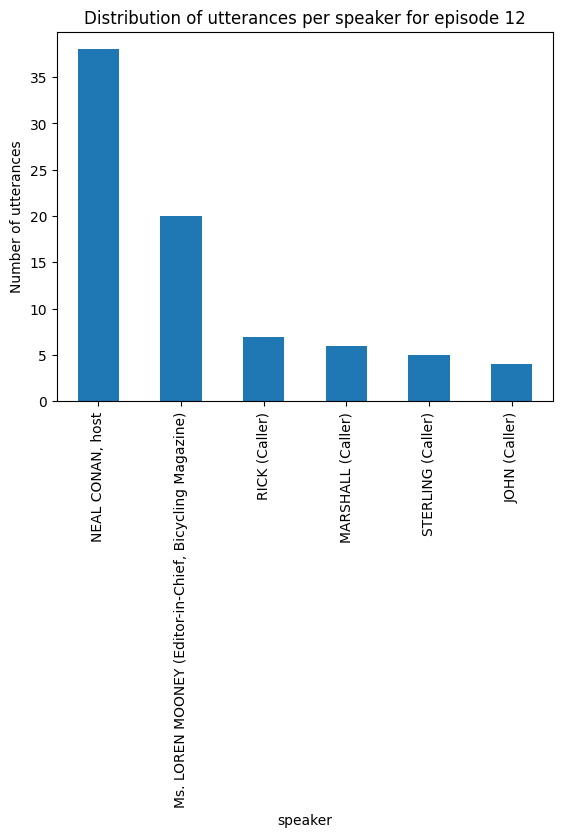

Episode: 58225
166
speaker
NEAL CONAN, host                                                                 74
Mr. DAVID SAVAGE (Supreme Court Reporter, Los Angeles Times, Chicago Tribune)    26
Mr. STEPHEN McALLISTER (Solicitor General, Kansas)                               21
Mr. MARC MAUER (Executive Director, The Sentencing Project)                      20
LINDA (Caller)                                                                   11
PAUL (Caller)                                                                     6
Solicitor General MCALLISTER                                                      5
BEVERLY (Caller)                                                                  3
Name: count, dtype: int64


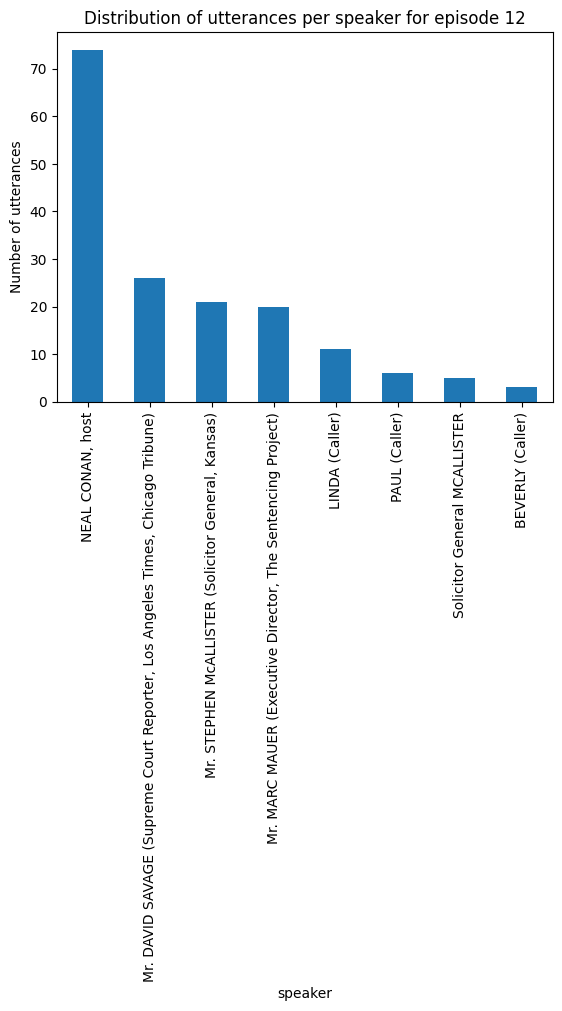

Episode: 75004
11
speaker
JON HAMILTON                                                                       6
Mr. ALEXIS FERNANDEZ (History Teacher)                                             2
Dr. GERRY BELL (Meteorologist, National Oceanic and Atmospheric Administration)    2
LIANE HANSEN, host                                                                 1
Name: count, dtype: int64


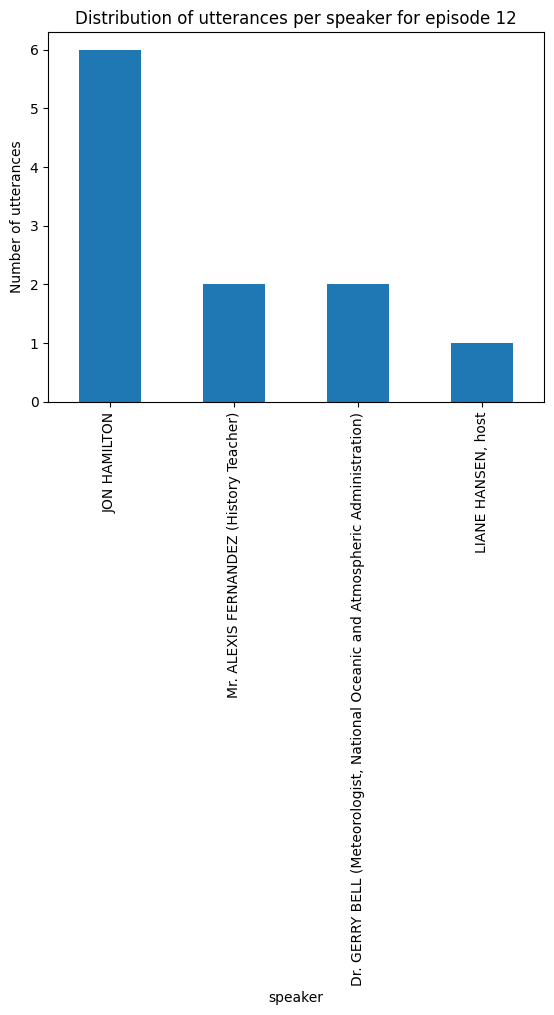

Episode: 74884
15
speaker
Ms. CHARLOTTE ABBOTT (Contributing Editor, Publishers Weekly)    8
SCOTT SIMON, host                                                7
Name: count, dtype: int64


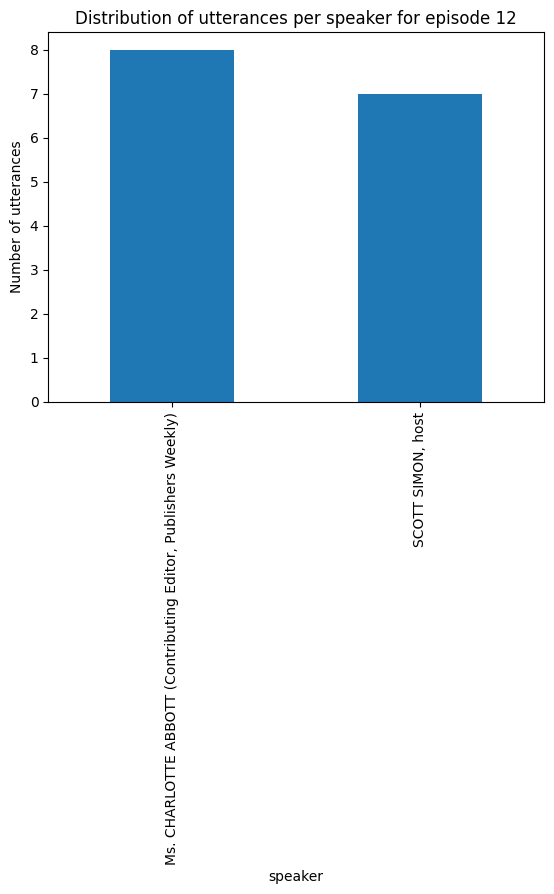

In [41]:
def plot_speaker_distribution_for_episode(df, episode):

    # print the episode
    print('Episode:', episode)

    # order the episodes from longest to shortest episode

    # Filter the dataframe for the specific episode
    df_episode = df[df['episode'] == episode]

    print(len(df_episode))

    # Group by 'speaker' and count the number of rows
    speaker_counts = df_episode['speaker'].value_counts()

    print(speaker_counts)

    # Plot a bar chart
    speaker_counts.plot(kind='bar')
    plt.ylabel('Number of utterances')
    plt.title(f'Distribution of utterances per speaker for episode {episode_order}')
    plt.show()

# iterate through the first 10 episodes
for episode in df['episode'].unique()[:4]:
    plot_speaker_distribution_for_episode(df, episode)

### We will find that the distribution of speakers is not equally split. Because many of these conversations are interviews, we will find one speaker overwhelmingly dominates the conversation. Further, outside callers into the show will imply that the members of a conversation vary as callers join and leave the conversation

In [9]:
df2sp = pd.read_csv('archive/utterances-2sp.csv')

In [10]:
display(df2sp.head(10))

,episode,episode_order,turn_order,speaker_order,host_id,is_host,utterance
0,1,1,0,0,0,True,The impeachment inquiry picks up tomorrow wher...
1,1,1,1,0,0,True,"Just this morning, the lawyer for the whistleb..."
2,1,1,2,0,0,True,There's are a lot of moving parts.
3,1,1,3,0,0,True,"Fortunately, NPR's Mara Liasson is here to help."
4,1,2,0,0,0,True,Good morning.
5,1,3,0,1,-1,False,"Good morning, Lulu."
6,1,4,0,0,0,True,All right.
7,1,4,1,0,0,True,What's the latest?
8,1,5,0,1,-1,False,"Well, the latest is that the lawyer for the fi..."
9,1,5,1,1,-1,False,The first whistleblower only had second and th...


### This is an alternative dataset of just 2-person conversations. This dataset limits what we are modeling to just 2 different speakers, but will avoid the issue of variable participants in a conversation

In [4]:
# remove all speakers labeled as _NO_SPEAKER
df = df[df['speaker'] != '_NO_SPEAKER']
print(len(df))

# group by episode
episodes = df.groupby('episode')

# show the first episode, 57264
display(episodes.get_group(57264))

3015435


,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."
...,...,...,...,...
3199423,57264,4,"NEAL CONAN, host",Joining us now from our bureau in New York is ...
3199424,57264,5,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",Thanks for having me.
3199425,57264,6,"NEAL CONAN, host","And I've got my copy of Bicycling Magazine, an..."
3199426,57264,7,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","Well, yes, it's true. Actually, the race did b..."
